# Explore nationalities in relation to evolution over time

In [123]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fanalysis.ca import CA
import scipy.stats as stats

### Create a Pandas dataframe from a SQL query

In [3]:
### Define the path to the file (a string in a variable 'db_file')
# if the data directory label is at the same level as the notebook,
# then the path is 'data/astronomers_import.db'
db_file_address = '../../data/astronomers_import.db'

In [4]:
### Create a connection to the SQLite database of your repository
# Beware : if the database does not exist at the specified address (db_file_address)
# it will be created and will be empty. Therefore, carefully check the database address
try:
    cn = sql.connect(db_file_address)    
except Exception as e:
    # if the connection does not work
    # an error message is raised
    print(e)    


In [5]:
### This ist the query that produces the data to be analysed.
# It has to be adapted to each use case
q1 = """
WITH tw1 AS (
SELECT natio_code, SUM(eff) as effectif_tot
from code_nationality_country
GROUP BY natio_code ),
--count each person just once
tw2 AS (
SELECT subject_uri, COUNT(*) eff, min(natio_country) natio_country, max(birthyear) birthyear
FROM dbp_person_countries dpc 
group by subject_uri)
SELECT tw2.birthyear, tw1.natio_code, tw1.effectif_tot
FROM tw2
   JOIN code_nationality_country cnc ON cnc.natio_country = tw2.natio_country 
   JOIN tw1 ON tw1.natio_code = cnc.natio_code 
WHERE LENGTH(cnc.natio_code) > 0
ORDER BY birthyear ;     
"""

In [6]:
### This instruction executes the query 
# then closes the connection to the database 
c_df= pd.read_sql_query(q1, cn)
cn.close()
# Inspect the first lines
print(c_df.head())

   birthyear natio_code  effectif_tot
0       1380   Austrian            72
1       1404    Italian           219
2       1423    Italian           219
3       1423   Austrian            72
4       1436     German           369


In [7]:
### Inspect maximum and minimum birth dates
print(c_df.birthyear.min(), c_df.birthyear.max())

1380 1993


In [9]:
### Exclude rows with 10 or less persons
c_df = c_df[c_df.effectif_tot > 10].sort_values(by=['natio_code','birthyear'])
print(c_df.tail())

      birthyear natio_code  effectif_tot
2027       1953      Swiss            56
2138       1961      Swiss            56
2162       1963      Swiss            56
2189       1966      Swiss            56
2195       1966      Swiss            56


In [12]:
### Count how many persons you have per country (natio_code): distribution
dc_df = c_df[['natio_code','effectif_tot']].groupby('natio_code').max()
dc_df

,effectif_tot
natio_code,
American,664
Argentinian,18
Austrian,72
British,300
Dutch,94
French,329
German,369
Indian,112
Italian,219


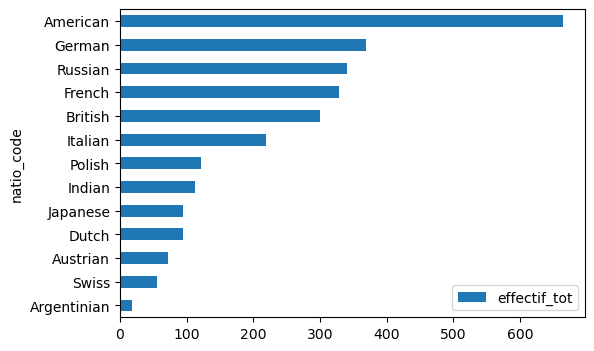

In [15]:
### Plot the distribution
dc_df.sort_values(by='effectif_tot').plot(kind='barh', figsize=(6,4))
plt.show()

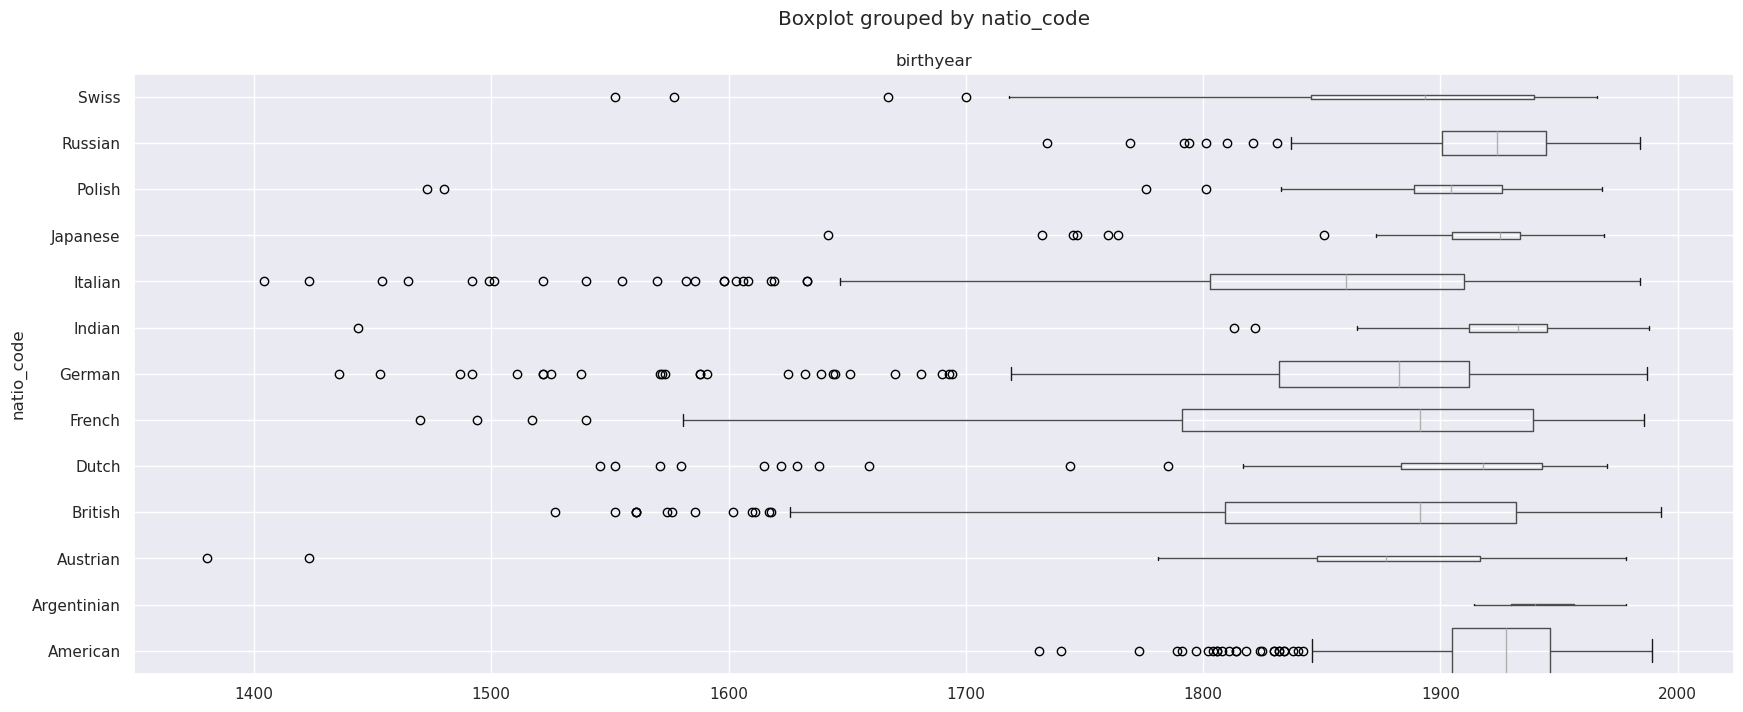

In [49]:
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
c_df.sort_values(by='natio_code', ascending=True).boxplot(column='birthyear', by='natio_code',  
          vert=False, widths=widths, figsize=(20,8))
plt.show()

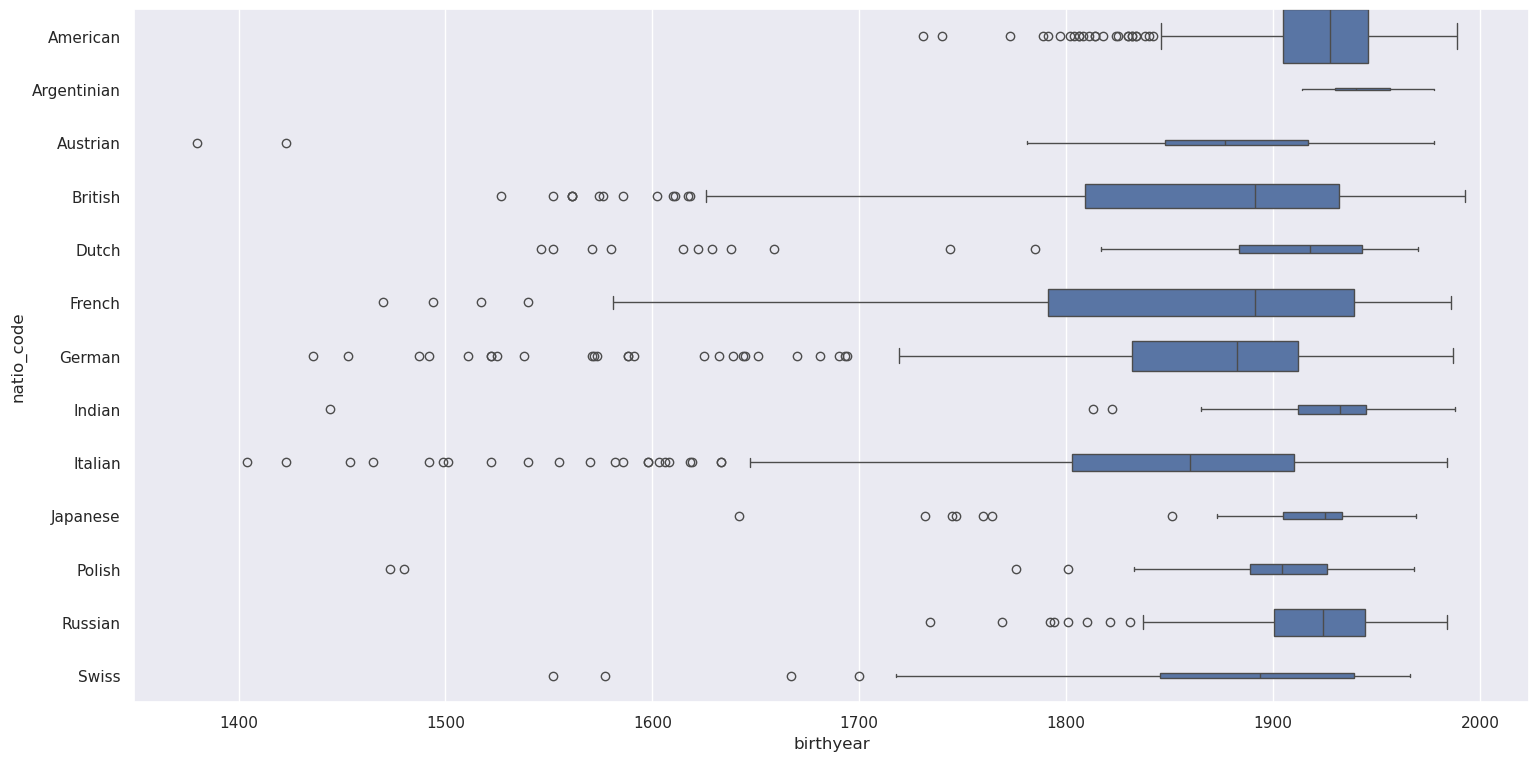

In [47]:
sns.set_theme(rc={'figure.figsize':(18,9)})

counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear, width=widths)
plt.show()

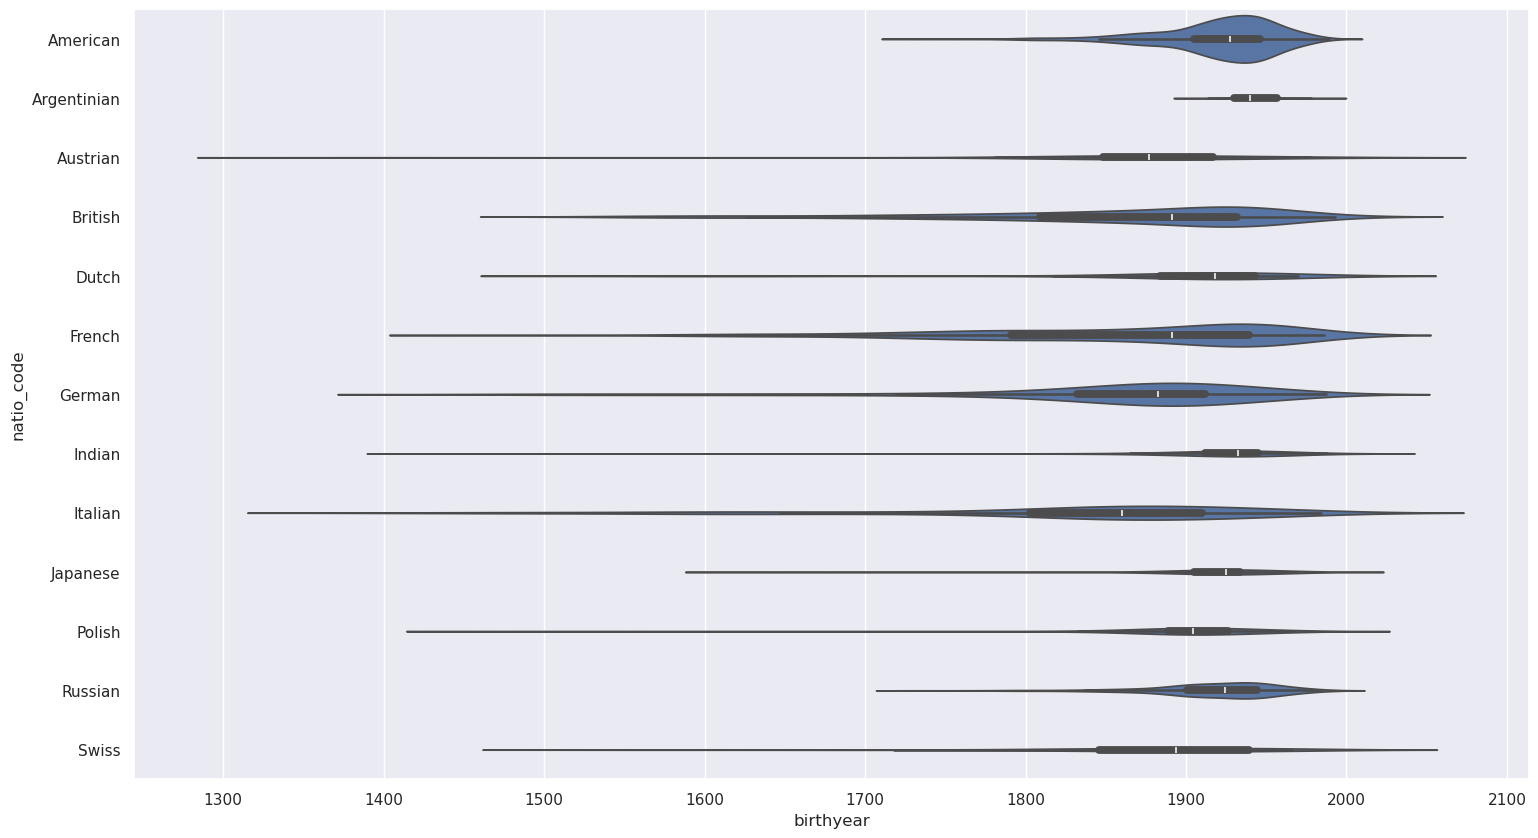

In [19]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')
plt.show()

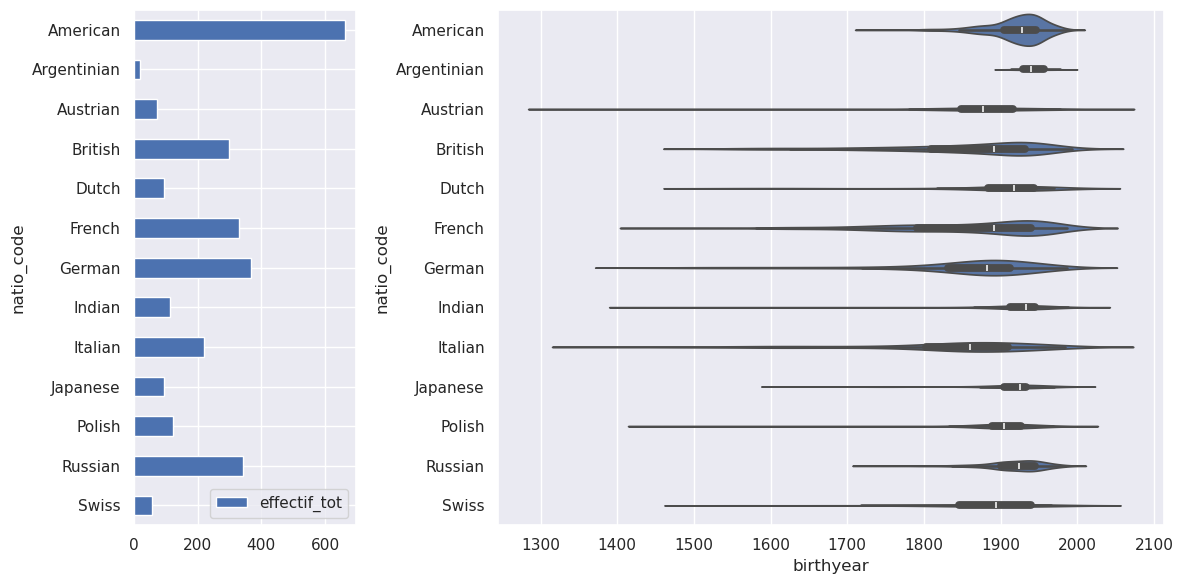

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, width_ratios=[1, 3])

gd_df = c_df[['natio_code','effectif_tot']].groupby(by=['natio_code']).max()\
      .sort_index(ascending=False).plot(kind='barh', figsize=(12,6), ax=ax1)

ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')

# évite les superpositions
fig.tight_layout()

plt.savefig('pictures/natio_code_birth_year_20241209.png')
plt.show()

## Correspondence factor analysis: time and country

In [66]:
print(min(c_df.birthyear), max(c_df.birthyear))

1380 1993


In [76]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1801, 2002, 25))
print(l_25)

[1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]


In [160]:
## Adapt values in relation to the time
l_years = [1351, 1501, 1601, 1701, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]

In [180]:
### fonction pd.cut
# This separation of periods isn't finegraded enough to make phenomena visible

c_df['Périodes'] = pd.cut(c_df.birthyear, l_years, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
150,1731,American,664,1701-1800
168,1740,American,664,1701-1800
215,1773,American,664,1701-1800


In [194]:
### fonction pd.qcut
# cuts the timeline in 10 periods with similar frequency of births, making them comparable

## test with 15 or 20 periods to see the difference

c_df['Périodes'] = pd.qcut(c_df.birthyear, q=15)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
150,1731,American,664,1379-1731
168,1740,American,664,1732-1807
215,1773,American,664,1732-1807


In [223]:
### group and count births
cdfp = c_df[['Périodes']].groupby(by='Périodes', observed=False).size()
cdfp.head()

Périodes
1379-1731    158
1732-1807    149
1808-1845    155
1846-1865    157
1866-1883    157
dtype: int64

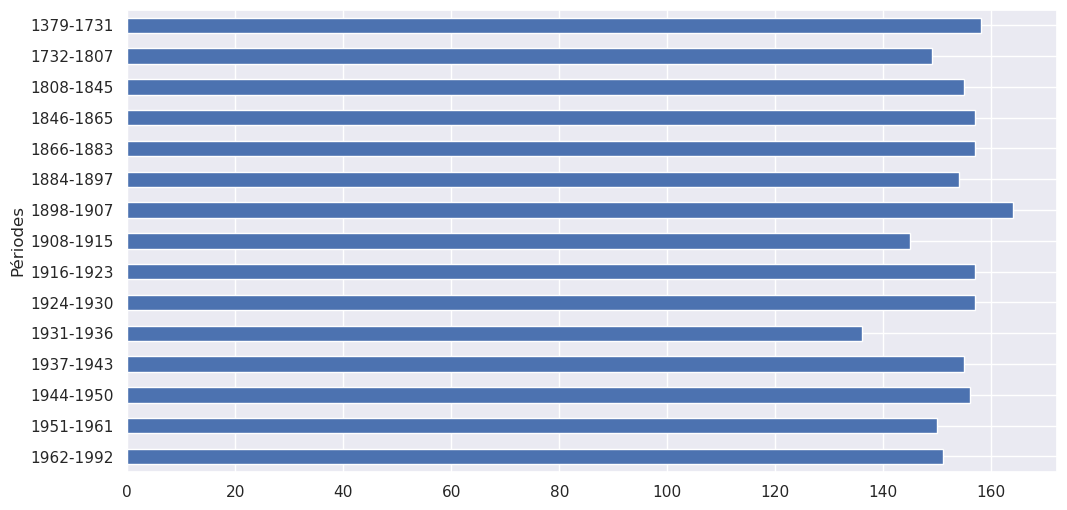

In [224]:
### group and count births
f = cdfp.sort_index(ascending=False).plot(kind='barh', figsize=(12,6))


In [198]:
## Calculate the pivot table 

X = 'Périodes'
Y = 'natio_code'

ddf = c_df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

natio_code,American,Argentinian,Austrian,British,Dutch,French,German,Indian,Italian,Japanese,Polish,Russian,Swiss,Total
Périodes,,,,,,,,,,,,,,
1379-1731,1,0,2,33,9,39,31,1,33,2,2,0,5,158
1732-1807,10,0,4,33,2,48,26,0,15,4,2,5,0,149
1808-1845,19,0,6,22,1,21,37,2,30,0,4,7,6,155
1846-1865,28,0,10,22,5,19,31,2,20,1,2,9,8,157
1866-1883,41,0,7,13,6,16,33,3,16,3,8,10,1,157
1884-1897,36,0,6,11,5,9,30,5,14,1,20,15,2,154
1898-1907,39,0,2,15,5,12,27,5,6,7,11,32,3,164
1908-1915,54,2,2,13,9,10,16,3,9,5,7,12,3,145
1916-1923,55,0,3,17,9,18,5,9,5,9,9,17,1,157


In [201]:
## Total number
n = ddf.iloc[-1,-1]
print(n)

2301


In [202]:
## Pivot table without borders
D = ddf.iloc[:-1,:-1].copy(deep=True)
# D

In [203]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 710.1650014803278 , dof : 168
p-value : 9.682792287510187e-68
phi2 = inertie (variance totale) : 0.30863320359857793
Cramer:  0.1603727958015786


In [204]:
# Calculate the factors of Factor correpondence analysis (FCA)
afc = CA(row_labels=D.index,col_labels=D.columns)

In [205]:
afc.fit(D.values)

CA(col_labels=Index(['American', 'Argentinian', 'Austrian', 'British', 'Dutch', 'French',
       'German', 'Indian', 'Italian', 'Japanese', 'Polish', 'Russian',
       'Swiss'],
      dtype='object', name='natio_code'),
   row_labels=Index(['1379-1731', '1732-1807', '1808-1845', '1846-1865', '1866-1883',
       '1884-1897', '1898-1907', '1908-1915', '1916-1923', '1924-1930',
       '1931-1936', '1937-1943', '1944-1950', '1951-1961', '1962-1992'],
      dtype='object', name='Périodes'))

In [207]:
#nombre de modalités ligne
K = D.shape[0]

#nombre de modalités colonnes
L = D.shape[1]

# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 15 , 13 ), effectif: 2301 , nombre max. facteurs: 12


In [208]:
#affichage des valeurs propres
print(afc.eig_)

[[1.84511703e-01 5.23361886e-02 2.31850385e-02 1.73052343e-02
  9.53656253e-03 6.60174568e-03 5.57380326e-03 4.56483602e-03
  2.82651515e-03 1.39331192e-03 6.62548302e-04 1.35716455e-04]
 [5.97834908e+01 1.69574070e+01 7.51216597e+00 5.60705528e+00
  3.08993408e+00 2.13902639e+00 1.80596358e+00 1.47904891e+00
  9.15816936e-01 4.51445892e-01 2.14671751e-01 4.39733811e-02]
 [5.97834908e+01 7.67408978e+01 8.42530638e+01 8.98601191e+01
  9.29500532e+01 9.50890796e+01 9.68950431e+01 9.83740920e+01
  9.92899090e+01 9.97413549e+01 9.99560266e+01 1.00000000e+02]]


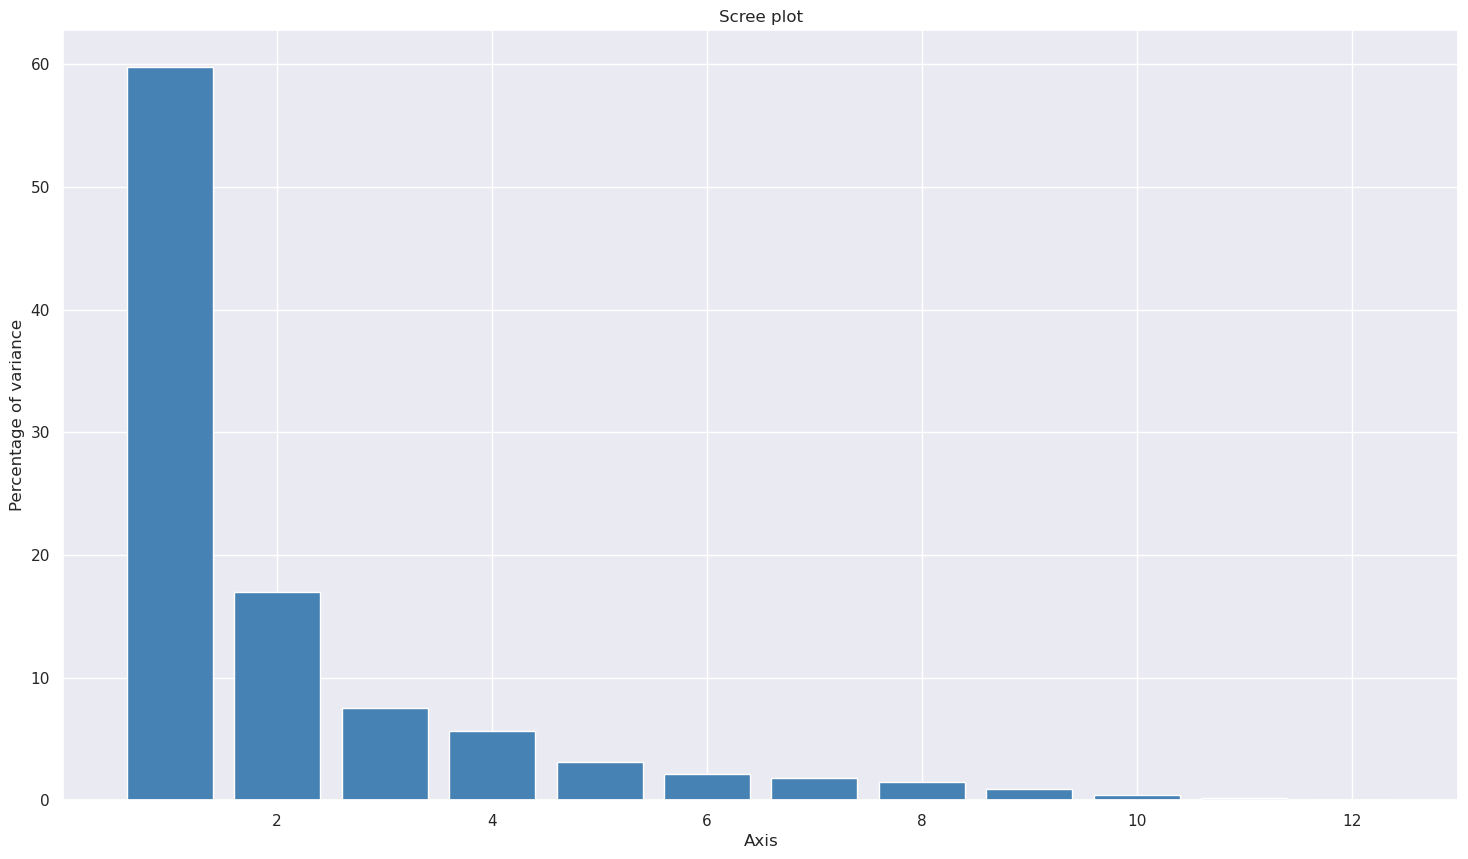

In [209]:
ax = afc.plot_eigenvalues('percentage')

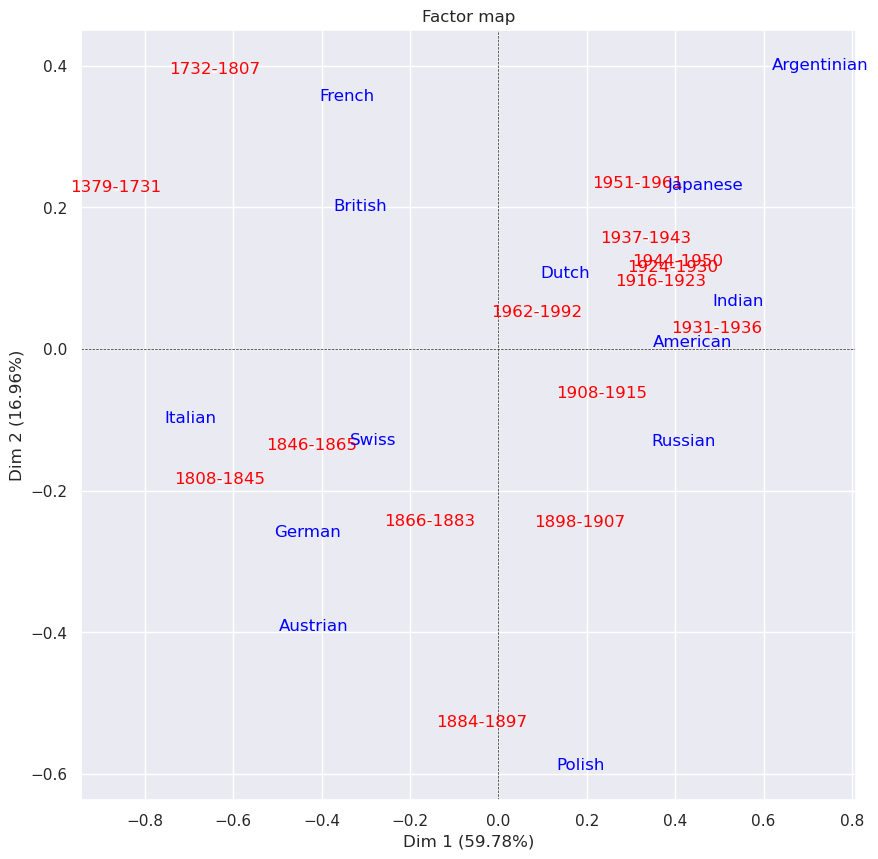

In [210]:
# First two factors
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

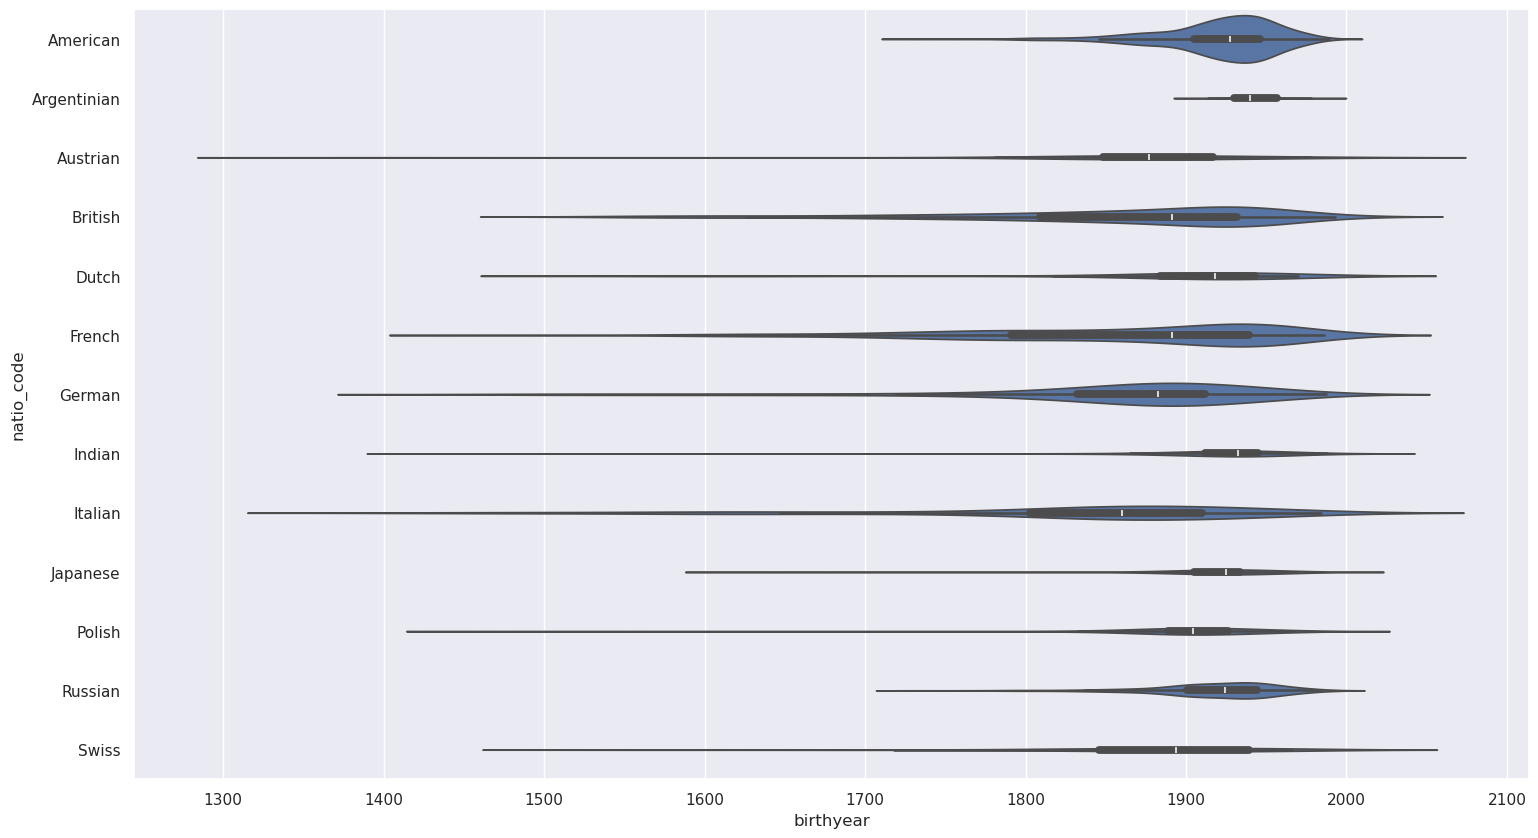

In [154]:
### Allows to inspect density zones and the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')
plt.show()

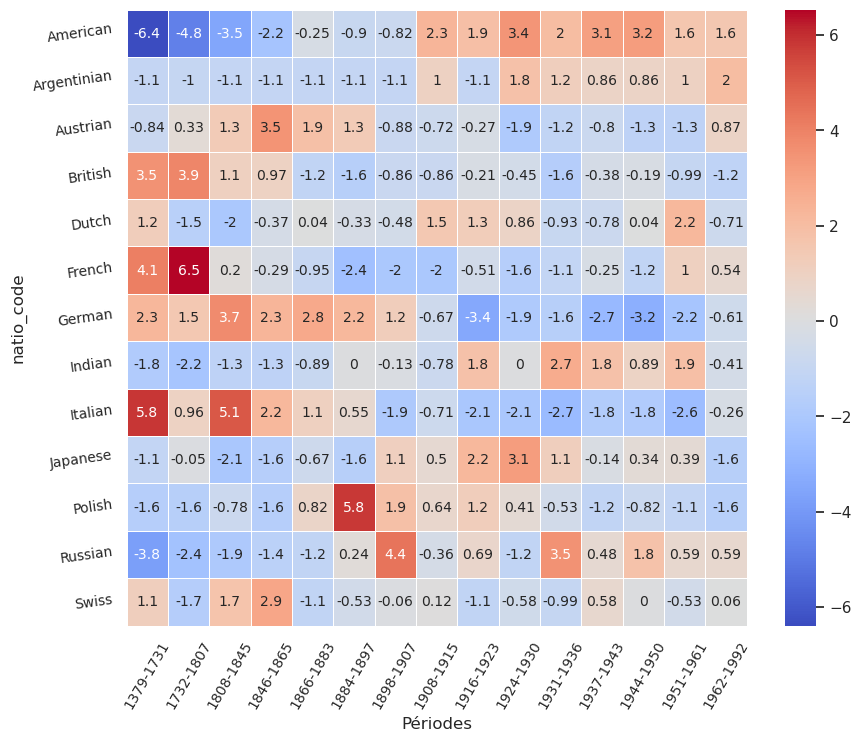

In [232]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index

residus_ponderes_T = residus_ponderes.transpose()

fig, ax = plt.subplots(figsize=(10,8))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes_T, annot=residus_ponderes_T, 
                cmap="coolwarm", linewidths=.5, ax=ax,
                annot_kws={"fontsize":10})
labels = residus_ponderes_T.index
cols = residus_ponderes_T.columns
c = g.set_xticklabels(cols, rotation=60, size=10)
p = g.set_yticklabels(labels, rotation=8, size=10)

plt.savefig('pictures/natio_code_birth_period_20241216.png')

plt.show()


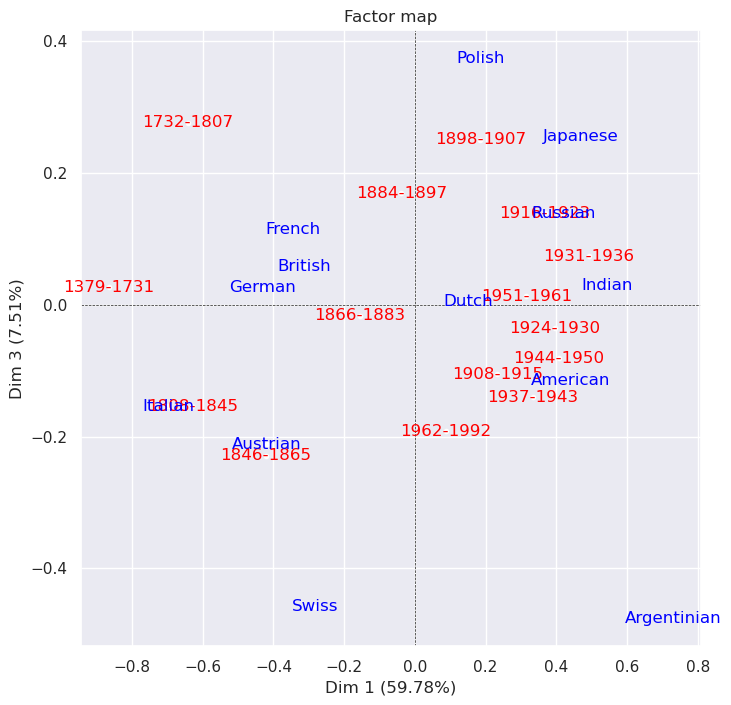

In [215]:
#représentation simultanée
afc.mapping(num_x_axis=1,num_y_axis=3,figsize=(8,8))